# Training Word2Vec in Bangla Corpus:

In this notebook, i will be using corpus from [this](https://scdnlab.com/corpus/) website.It is a fully categorised full corpus set.This dataset is created from prominent and popular newspapers from Bangladesh.It is created on varied domains like Accident,Art,Crime,Economics,Education,Entertainment,Environment,International,Opinion,Politics,Science and Tech  Sports.I used this whole corpus and created a dataset which is a collection of about 2 million sentences.This dataset will be used for Word2Vec.

# Importing Packages and Libraries:
For the training of Word2Vec,i will be using Gensim.It is a widely used library for NLP works.

Gensim is an open-source library for unsupervised topic modeling and natural language processing.

In [ ]:
import pandas as pd
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
import glob
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from time import time 
from collections import defaultdict

 # Stemming 
To stem the bangla words i have used a Bangla Stemmer.I have used [this](https://pypi.org/project/bangla-stemmer/) package.

To activate this stemmer please turn on your internet option in kaggle notebook and run the command below.

It is a rule based stemmer.

In [ ]:
#turn on internet option in kernel
!pip install bangla-stemmer

In [ ]:
from bangla_stemmer.stemmer import stemmer

# Predefined Functions:
1.text_to_word_list()-->This function is used to convert sentence into wordlist.It is necessary to prepare the input for word2vec.


2.replace_strings()--> This function is used to remove emoji,Engish Words etc from the sentences.


3.stopwordRemoval()--> I have a dataset for Bangla stopwords.This function removes stopwords from sentence.


4.remove_punctuations()--> This function is used for removing many UNICODE punctuations that are not in general list but the are quite often  used in Bangla texts.


5.joining()-->This joins the word list back into a sentence.


6.preprocessing()-->This function calls both replace_string() and remove_punctuations() function.


7.Stemming()-->This function stem all the words in a sentence.

In [ ]:

def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]
    
    out=' '.join(stm)
    
    return str(out)

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out


def Stemming(text):
    
    x=str(text)
    l=x.split()

    stmr = stemmer.BanglaStemmer()
    stm = stmr.stem(l)

    out=' '.join(stm)
    
    return str(out)


### Datasets are loaded here:
The datasets are the corpus and the stopwordslist.


In [ ]:
df =pd.read_csv('/kaggle/input/corpus/main_dataset_v3.csv')
data1 =pd.read_excel('/kaggle/input/bangla-stopwords/stopwords_bangla.xlsx')
stop = data1['words'].tolist()

I have only taken the sentences which are only in limited range if 100 to 1.

In [ ]:

df = df[(df['Sentence'].str.len()<100)&(df['Sentence'].str.len()>1)]
df['Sentence'].apply(lambda x: len(str(x))).plot(kind='hist');

# Preprocessing

As the first step of preprocessing,I have cleaned the datase from unnecessary things with my predefined function Preprocessing().

In [ ]:
df['Sentence'] = df.Sentence.apply(lambda x: preprocessing(str(x)))

Here i have applied Stemming.

In [ ]:
#df['Sentence'] = df.Sentence.apply(lambda x: Stemming(str(x)))

Stopwords removal function is applied here.

In [ ]:
df['Sentence'] = df.Sentence.apply(lambda x: stopwordRemoval(str(x)))

A histogram is plotted here to visualize the dataset characteristics.

In [ ]:
df['Sentence'].apply(lambda x: len(str(x))).plot(kind='hist');
df.reset_index(drop=True, inplace=True)

Preprocessed sentences are converted into wordlist as the word2vec requiers word list for each sentence.

In [ ]:
df['Sentence'] = df.Sentence.apply(lambda x: text_to_word_list(str(x)))
word2vecinput = [row for row in df.Sentence]

Now we will run word2vec.The description about the parameter i used.

1.sentences (iterable of iterables, optional) – The sentences iterable can be simply a list of lists of tokens, but for larger corpora, consider an iterable that streams the sentences directly from disk/network.


2.size (int, optional) – Dimensionality of the word vectors.Here i have used 400.It is the dimension of our embeddings.


3.window (int, optional) – Maximum distance between the current and predicted word within a sentence.


4.sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.CBOW sometimes get better result,so i used it.


5.negative (int, optional) – If > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.


6.workers (int, optional) – Use these many worker threads to train the model (=faster training with multicore machines).


# Training Model

In [ ]:

model = Word2Vec(word2vecinput, size=400, window=20, min_count=5,sg=0,negative=3,workers=multiprocessing.cpu_count()-1)


# Result

here we can see that our trained Word2vec embeddings is well trained.As we can see from examples,it can predict the similar words pretty good.

In [ ]:
print(model.wv.most_similar("মা", topn=5))

In [ ]:
print(model.wv.most_similar("খুলনা", topn=5))

In [ ]:
print(model.wv.most_similar("রোজা", topn=5))

In [ ]:
print(model.wv.most_similar("অপরাধ", topn=5))

Here the function compute cosine similarity between two words.We can see that words are very similar as the value.



In [ ]:
print(model.wv.similarity('ঋণ', 'ব্যাংক'))

The embeddings of word2vec can also detect that which word is not relatable and odd respective to other words in a sentence.

In [ ]:
print(model.wv.doesnt_match("বার্সেলোনা ফুটবল গোলকিপার রাজনীতি".split()))


# Visualization

We can also saved the embeddings for further use.Now We will visualize it.

In [ ]:
model.wv.save_word2vec_format('corpus')
#python -m gensim.scripts.word2vec2tensor --input model_name --output model_name
#python -m gensim.scripts.word2vec2tensor --input model_name --output model_name

Google came up with their new tool for creating visualization for high dimensional data such as word embeddings. It’s called 
embedding projector.We will use the saved model to create this visualize it.It’s called embedding projector.[Here](https://projector.tensorflow.org/) it is.They have pre-loaded visualization for MNIST dataset, Iris dataset, etc that you can play with and get used to the tool.It also provides an option to load your own word embedding data for visualization.We are going to do that thing now.After running this command,this command will generate two files: TSV file and Metadatafile.The TSV will contain all the vectors and Metadata will contain labels associated with the vectors.

In [ ]:
!python -m gensim.scripts.word2vec2tensor --input corpus --output corpus

After downloading the data from kaggle kernel,You can use the load data option in the tensorflow projector where you can select your 

TSV and metadatafiles.Before loading the data it will look like this.

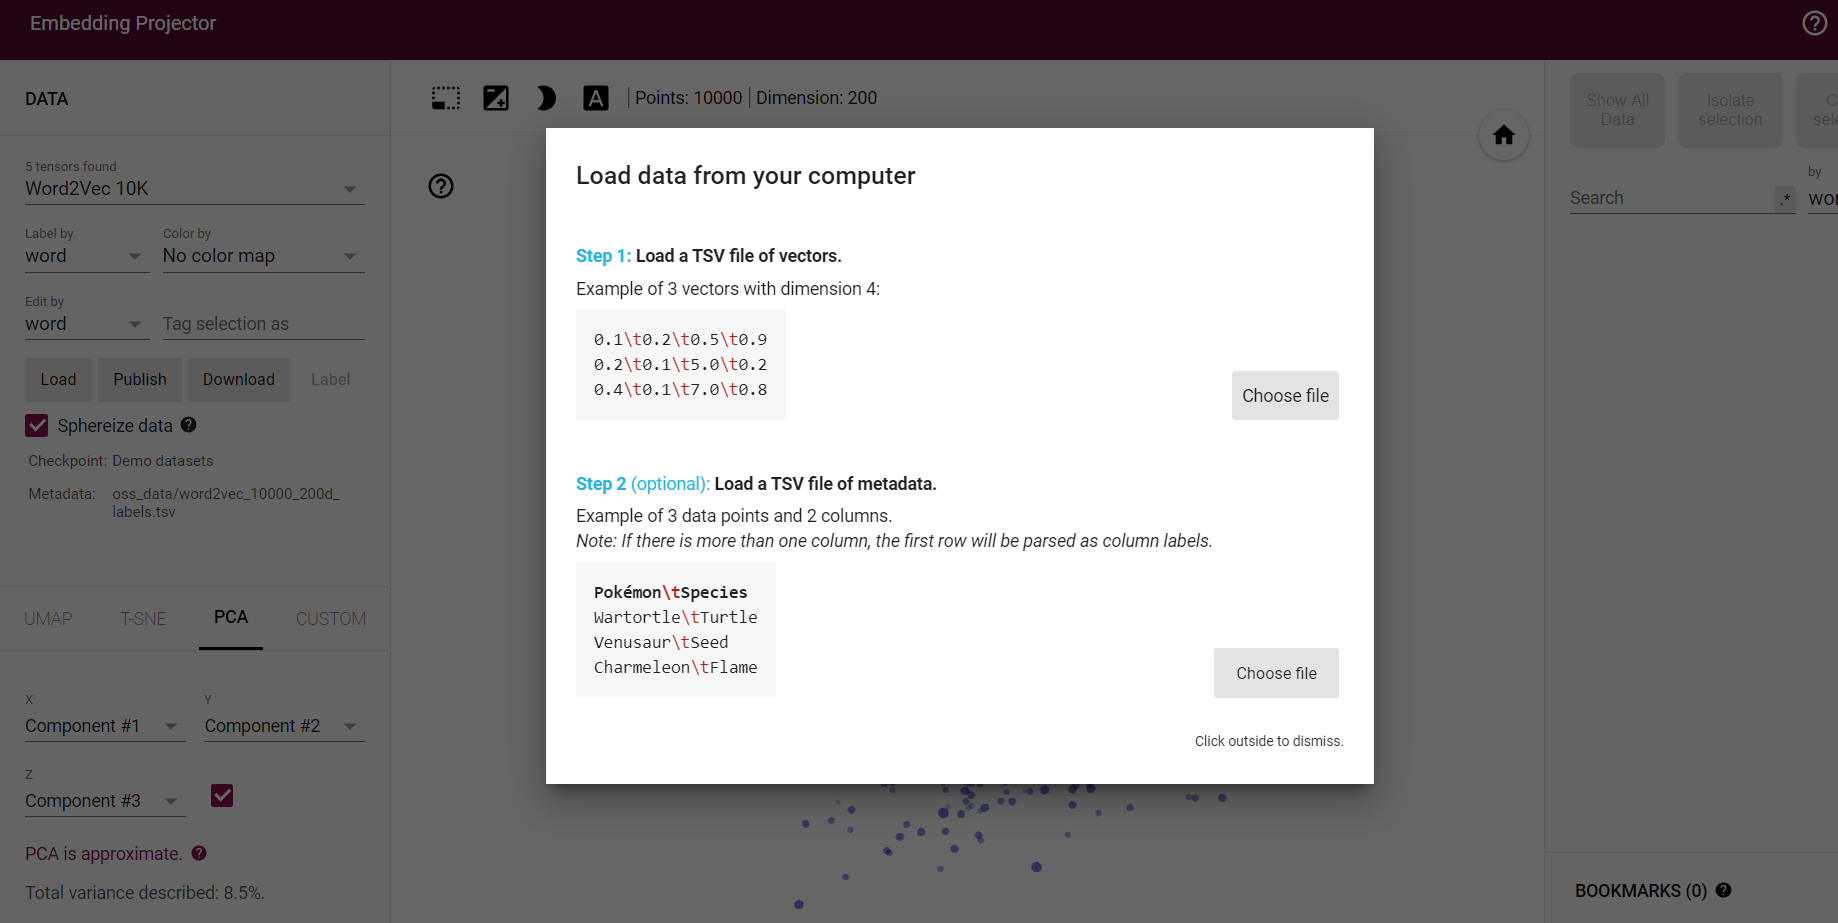

After loading the data files,The embeddings will look something like this.It is the embedding in projected in 3D space.

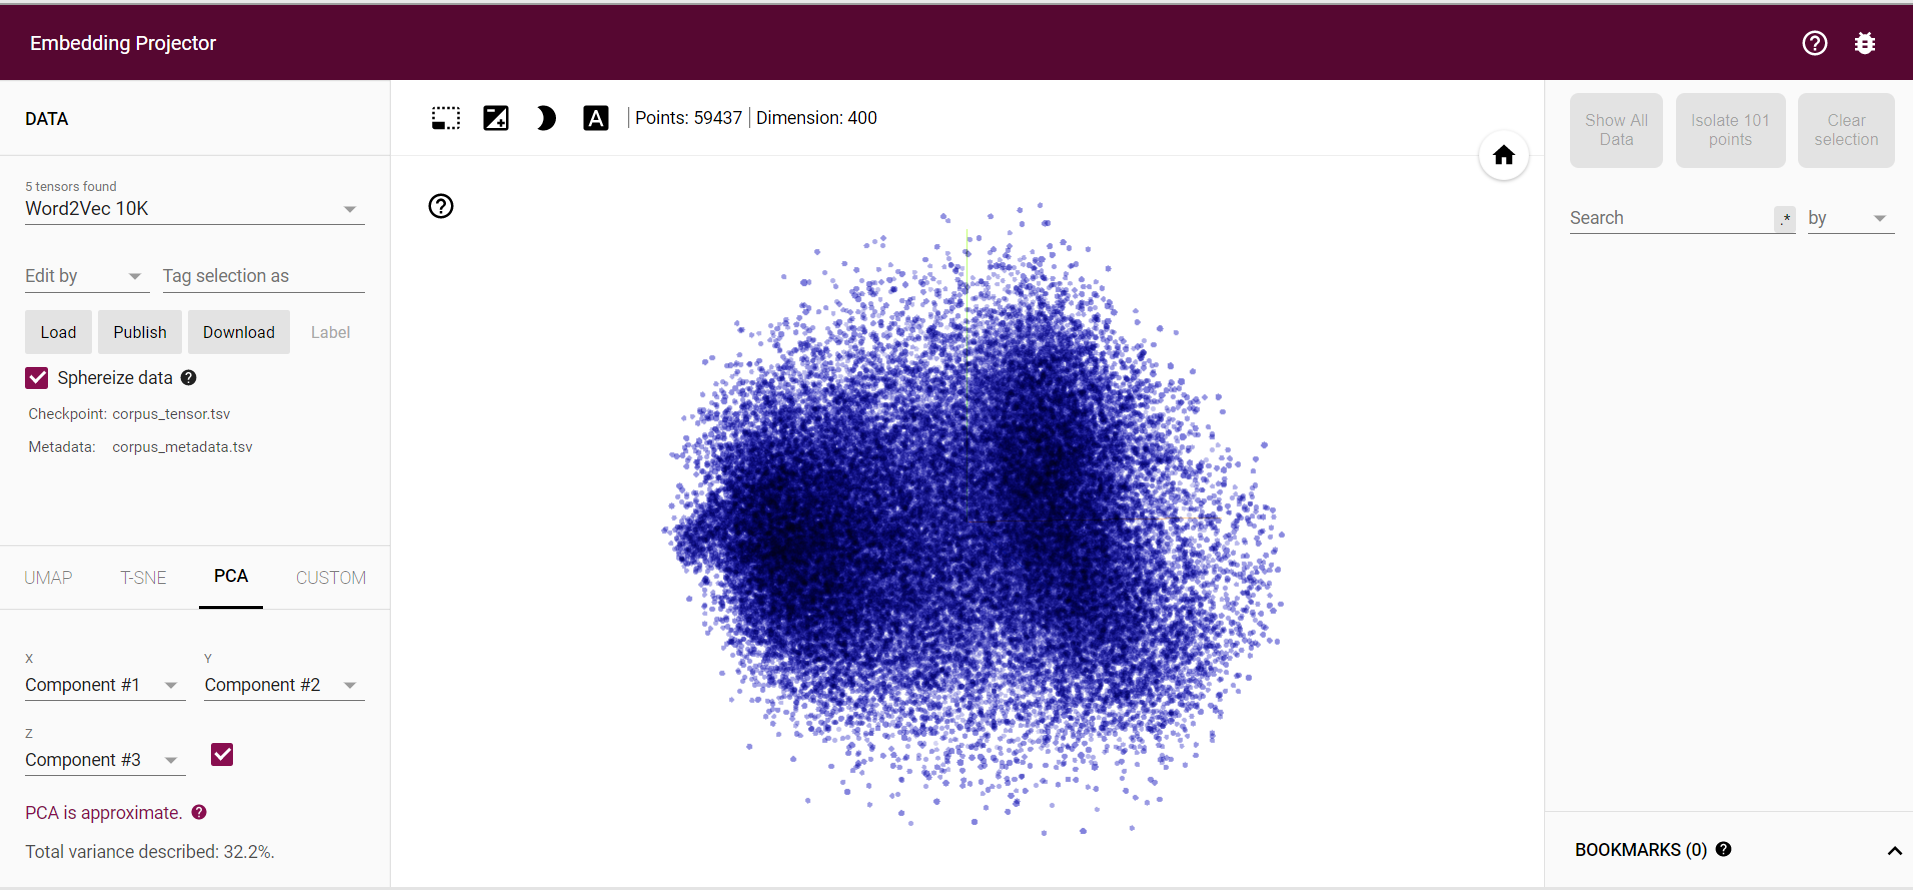

You can play with words and see their embeddings by searching on the right side.